In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

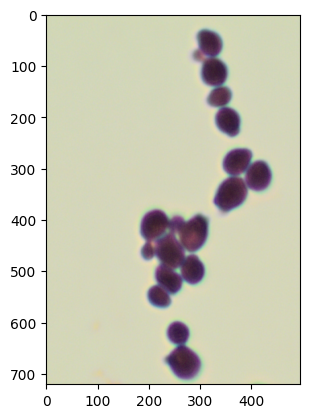

In [77]:
image_name = "./dataset/png/Candida.albicans_0017.png"
image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
plt.imshow(image)

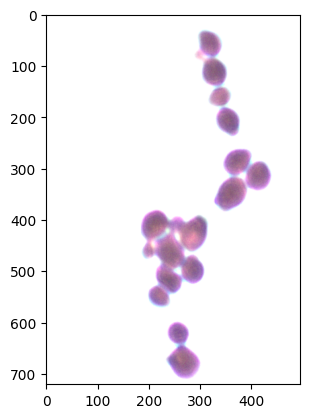

In [78]:
alpha = 1.5 # Contrast control (1.0-3.0)
beta = 50 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

plt.imshow(adjusted)

# Blue-focused grayscale transformation

In [79]:
RED_W = 0
BLUE_W = 1
GREEN_W = 0

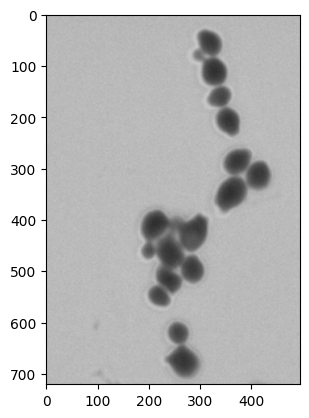

In [80]:
x, y, channels = image.shape
grayscale_image = np.zeros((x,y), np.uint8)

for i in range(x):
    for j in range(y):
        r,g,b = image[i,j]
        grayscale_image[i,j] = np.uint8((RED_W * r + BLUE_W * b + GREEN_W * g) / (RED_W + BLUE_W + GREEN_W))
    
plt.imshow(grayscale_image, cmap='gray', vmin=0, vmax=255)

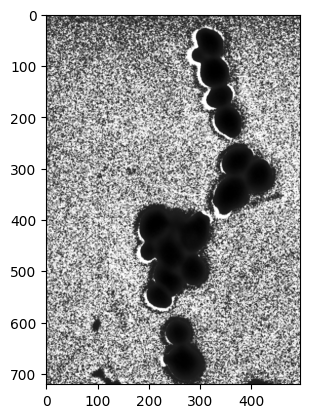

In [81]:
image_eq = grayscale_image.copy()
cv2.equalizeHist(grayscale_image, image_eq)
plt.imshow(image_eq, cmap='gray', vmin=0, vmax=255)

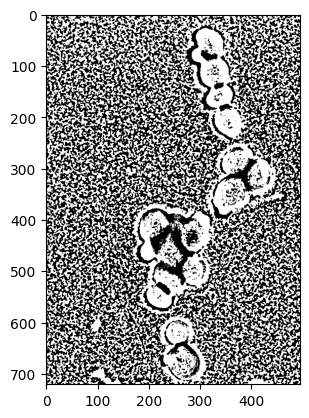

In [82]:
dest = cv2.GaussianBlur(image_eq, (3, 3), 0)
binarized_image = cv2.adaptiveThreshold(dest, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 1)
plt.imshow(binarized_image, cmap='gray', vmin=0, vmax=255)

# binarization

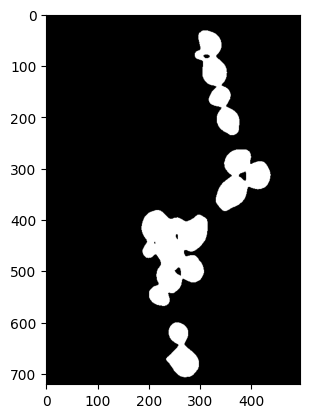

In [83]:
grayscale_image = cv2.GaussianBlur(grayscale_image, (5,5), 0)
_, binarized_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binarized_image, cmap='gray', vmin=0, vmax=255)

# Watershed

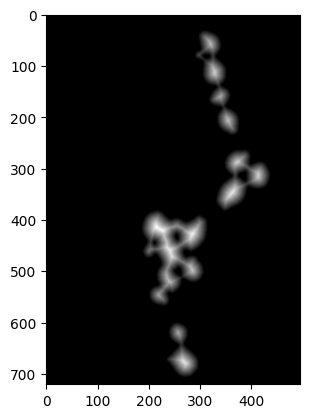

In [84]:
dist_transform = cv2.distanceTransform(binarized_image, cv2.DIST_L2, 3, dstType=cv2.CV_8U)
cv2.normalize(dist_transform, dist_transform, 0, 255, cv2.NORM_MINMAX)
plt.imshow(dist_transform, cmap='gray', vmin=0, vmax=255)

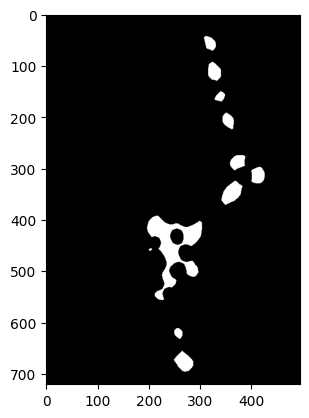

In [85]:
dist_transform = cv2.morphologyEx(dist_transform, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)

_, dist = cv2.threshold(dist_transform, 100, 255, cv2.THRESH_BINARY)

dist = cv2.morphologyEx(dist, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)

plt.imshow(dist, cmap='gray', vmin=0, vmax=255)

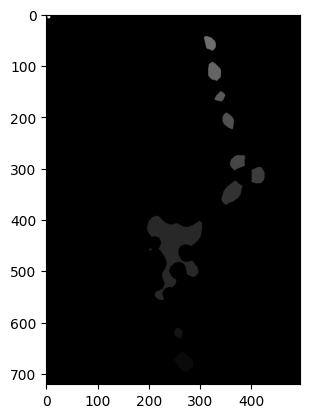

In [86]:
# Create the CV_8U version of the distance image
# It is needed for findContours()
dist_8u = dist.astype('uint8')
# Find total markers
contours, _ = cv2.findContours(dist_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv2.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')

plt.imshow(markers_8u, cmap='gray', vmin=0, vmax=255)

In [87]:
from random import randint

# Perform the watershed algorithm
watershed_result = cv2.watershed(suppressed_image, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv2.bitwise_not(mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((randint(0,256), randint(0,256), randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

# Visualize the final image
print(f"Found {len(contours)} bacterias")
plt.imshow(dst)

NameError: name 'suppressed_image' is not defined

# Show marker outlines on original image

In [ ]:
result_image = image.copy()
result_image[watershed_result == -1] = [255,0,0]
plt.imshow(result_image)

In [ ]:
plt.imshow(watershed_result)